In [1]:
#Import all libraries
import pandas as pd
import re
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from gensim import corpora, models
import numpy as np
import matplotlib.colors as mcolors
import random
import calendar
import string

In [2]:
#Set up txt file directory and directory to save figures to
#By default, the code runs with a randomly generated chat
#Feel free to change it to your own conversations and explore the insights they offer!
file = "WhatsApp Chat with Test Group.txt"
#If you do not want to save figures, just comment the directory line and change savefigs to False
directory = "/Users/selbl/Downloads//"
savefigs = True

In [3]:
#Get group name
#This can be obtained from the file name and finding what is between with and .txt
sub1 = "with "
sub2 = ".txt"
s=str(re.escape(sub1))
e=str(re.escape(sub2))
# printing result
nombregrupo=re.findall(s+"(.*)"+e,file)[0]
#Define the column names of the databases we work with
column_names = ["Date", "Time", "Sender","Message"]

In [4]:
#Initialize an empty dataframe
df = pd.DataFrame(columns = column_names)
#Work with each line
with open(file,encoding="utf8") as f:
    #Obtain text
    lines = f.readlines()
    #Iterate over lines
    for line in lines:
        #Check if it has delimiters
        if (", " in line) and (": " in line) and (" - " in line):
            #Split
            splitline = re.split(', | - |: ',line)
            #Delete the \n value
            splitline[len(splitline)-1] = splitline[len(splitline)-1].replace("\n","",1)
            #Create line as a dictionary and then a dataframe
            line = {'Date' : splitline[0], 'Time' : splitline[1], 'Sender' : splitline[2],"Message":splitline[3]}
            line = pd.DataFrame([line])
            #Add to dataframe
            df = pd.concat([df,line],ignore_index=True)

In [5]:
#Get stop words for filtering
stop_words = set(stopwords.words('english'))
#Get special characters for filtering
#Create dictionary with the items to be deleted
del_dict = {sp_character: '' for sp_character in string.punctuation}
#Add the space character
del_dict[' '] = ''
#Create reference table
table = str.maketrans(del_dict)
#Create filtered database
dfFilter = df
#Obtain length of the filtered database (important for later)
largo = len(dfFilter)
#Iterate over sample to eliminate stop words
for i in range(largo):
    #Extract message
    message = df.at[i,"Message"]
    #Tokenize
    word_tokens = word_tokenize(message)
    #Filter stop words
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    #This filter still returns certain punctation and special characters which we do not care about
    #Hence why I get rid of them    
    filtered_sentence = [val.translate(table) for val in filtered_sentence]
    #Create coherent message
    fd = ""
    for x in filtered_sentence:
        fd = fd + x + " "
    #Remove final space
    fd = fd[:-1]
    #Add in database
    dfFilter.at[i,"Message"] = fd

In [6]:
#OPTIONAL CELL
#Now I turn my attention to senders
#In groups with a lot of people, it sometimes gets hard to track who sent which message
#One way to circumvent this is to only take the first word in the senders name
#To do so, I run the following
dfFilter['Sender'] = dfFilter['Sender'].str.split().str[0]

In [7]:
#Obtain different senders
Senders = list(set([sender for sender in dfFilter['Sender']]))

In [8]:
#It is useful to stick to a colour palette for all of the senders
#To do so, I will generate a sequence of colours that is dependent on the number of senders
#First initialize colours
colours = list(mcolors.CSS4_COLORS.keys())

In [9]:
#OPTIONAL CELL
#Because transparent colours are hard to see, I eliminate them from consideration
#You can choose to skip this cell if you want to have those light colours
transparent_colours = ['lightgray','lightgrey','whitesmoke','white','snow','mistyrose','lightcoral','seashell',
                      'peachpuff','linen','bisque','antiquewhite','papayawhip','bisque','lemonchiffon','beige','blanchealmond','oldlace',
                     'floralwhite','cornsilk','ivory','lightyellow','lightgoldenrodyellow','honeydew',
                     'mintcream','azure','lightcyan','lightskyblue','aliceblue','lightsteelblue','ghostwhite',
                     'lavender','lavenderblush','lightpink']
#eliminate them from consideration
colours = [x for x in colours if x not in transparent_colours]

In [10]:
#Create the function for the random colour generation
def random_color_generator(colors):
    color = random.choice(colors)
    return color

#Create a function that

In [11]:
#Create the color scheme
#Get number of senders
num_senders = len(Senders)
#Initialize the empty list that stores the colours
colorscheme = random.sample(colours, num_senders)
#Store colorscheme as a dictionary as well. This is for easing plotting
colour_dict = {}
conti = 0
for sender in Senders:
    colour_dict[sender] = colorscheme[conti]
    conti = conti + 1

In [12]:
#We obtain the first year by looking at the first message, same with first month
splitline_date = re.split('/',dfFilter.iloc[0]['Date'])
anio = 2000 + int(splitline_date[2])
mes = calendar.month_name[int(splitline_date[0])]

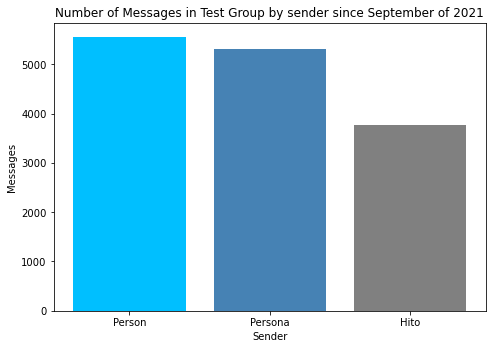

In [13]:
#Get a graph of different messages by sender
#Get the number of messages
NumMessages = [sum(dfFilter['Sender'] == sender) for sender in Senders]
#Generate the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Messages')
ax.set_xlabel('Sender')
ax.set_title(f'Number of Messages in {nombregrupo} by sender since {mes} of {anio}')
ax.bar(Senders,NumMessages,color=colorscheme)
if savefigs:
    plt.savefig(directory[:-1] + "Global Messages.png")
plt.show()

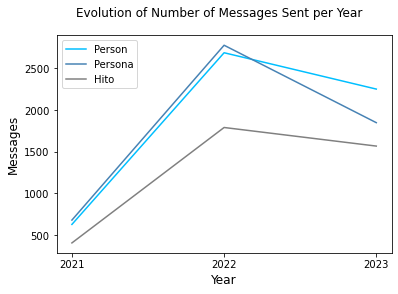

In [14]:
#Yearly segmentation
#Obtain the evolution of messages per year
#Define years
#obtain last year from og year
c = dfFilter['Date'].str.extract('.*(\d{2})', expand = False)
last_year = 2000 + int(c.iloc[-1])
#Obtain range of years
diff_year = last_year - anio + 1

#Obtain distinct last digit of years
years = [anio + x for x in range(0,diff_year)]
#Define dictionary
vals2 = {}
#Obtain counts
for year in years:
    vals2[year] = {}
    #subset dataframealse)
    cont = Counter(dfFilter[dfFilter['Date'].str.extract('.*(\d{2})', expand = False) == str(year - 2000)]['Sender']).most_common(len(Senders))
    #Check if somebody is missing
    #Check if length is different
    if len(cont) < len(Senders):
        #If so, find which ones are not in the count
        PresentSenders = [cont[i][0] for i in range(len(cont))]
        for sender in Senders:
            if sender not in PresentSenders:
                cont.append((sender,0))
    #Obtain return list
    #vals2[year] = [cont[x][1] for x in range(len(Senders))]
    #vals2[year] = [cont[x][1] for x in range(len(cont))]
    #Messy solution but should work
    for i in range(len(cont)):
        #Get sender
        send = cont[i][0]
        #Get number of messages
        nro = cont[i][1]
        #Add to dictionary
        vals2[year][send] = nro
#Create histograms
#Yearly data
#data = [vals2[year] for year in years]
    
#Plot the evolution
fig = plt.figure()
#cont = 0
for sender in Senders:
    #Get messages:
    messages = [vals2[year][sender] for year in years]
    #plt.plot(years,[vals2[year][cont] for year in years], label=sender, color = colorscheme[cont])
    plt.plot(years,messages, label=sender, color = colour_dict[sender])    
    #cont = cont + 1
    
fig.suptitle('Evolution of Number of Messages Sent per Year', fontsize=12)
plt.xticks(range(anio,last_year+1))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Messages', fontsize=12)
plt.legend(loc="best")
if savefigs:
    plt.savefig(directory[:-1]+ "Evolution Messages.png")
plt.show() 


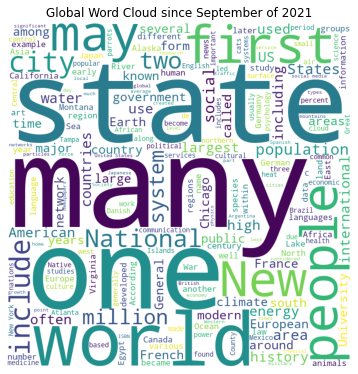

In [15]:
#Global Word Cloud

all_words = '' 

#looping through all incidents and joining them to one text, to extract most common words
for arg in dfFilter['Message']: 
    tokens = arg.split()  
    #Remove media and omitted if they exist
    if ('Media' in tokens):
        tokens.remove('Media')
    if ('omitted' in tokens):
        tokens.remove('omitted')
    #Remove most common letters
    if ('s' in tokens):
        tokens.remove('s')
    if ('m' in tokens):
        tokens.remove('m')
    #Join
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='white', 
                min_font_size = 10,normalize_plurals=False).generate(all_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.title("Global Word Cloud since " + mes + " of " + str(anio))
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
if savefigs:
    plt.savefig(directory[:-1] + "WordCloud Global.png")
plt.show()

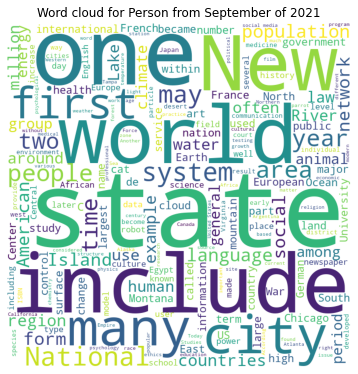

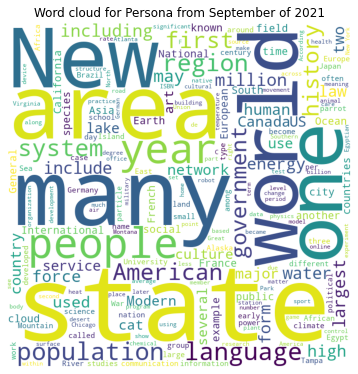

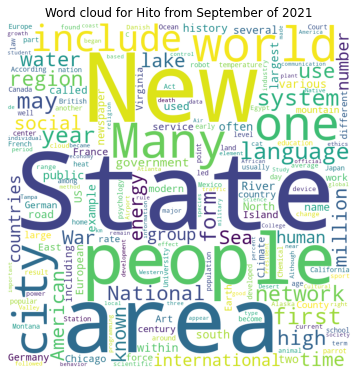

In [16]:
#One worldcloud per person
#Obtain senders
for sender in Senders:
    all_words = ''   
    #Create subdf with only their messages
    dfFilter2 = dfFilter[dfFilter['Sender'] == sender]
    #looping through all incidents and joining them to one text, to extract most common words
    for arg in dfFilter2['Message']: 
    
        tokens = arg.split()  
        #Remove media and omitted if they exist
        if ('Media' in tokens):
            tokens.remove('Media')
        if ('omitted' in tokens):
            tokens.remove('omitted')
        #Remove most common letters
        if ('s' in tokens):
            tokens.remove('s')
        if ('m' in tokens):
            tokens.remove('m')
        
        all_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 700, height = 700, 
                    background_color ='white', 
                    min_font_size = 10).generate(all_words) 
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.title(f"Word cloud for {sender} from {mes} of {anio}")
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    if savefigs:
        plt.savefig(directory[:-1] + "WordCloud for" + sender + ".png")   
    plt.show()

In [17]:
#Conduct sentiment analysis
# Initialize the VADER Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment polarity
def get_sentiment_polarity(message):
    sentiment_scores = sid.polarity_scores(message)
    return 'positive' if sentiment_scores['compound'] >= 0.05 else 'negative' if sentiment_scores['compound'] <= -0.05 else 'neutral'

# Apply the sentiment analysis to the 'Message' column
dfFilter['Sentiment'] = dfFilter['Message'].apply(get_sentiment_polarity)

# Calculate the percentage of each sentiment for all messages
sentiment_percentage_all = dfFilter['Sentiment'].value_counts(normalize=True) * 100

# Calculate the percentage of each sentiment per sender
sentiment_percentage_per_sender = dfFilter.groupby(['Sender', 'Sentiment']).size().unstack(fill_value=0)
sentiment_percentage_per_sender = sentiment_percentage_per_sender.div(sentiment_percentage_per_sender.sum(axis=1), axis=0) * 100

# Display the results
print("Sentiment Percentage for All Messages:")
print(sentiment_percentage_all)
print("\nSentiment Percentage per Sender:")
print(sentiment_percentage_per_sender)

Sentiment Percentage for All Messages:
neutral     76.302831
positive    15.175763
negative     8.521406
Name: Sentiment, dtype: float64

Sentiment Percentage per Sender:
Sentiment  negative    neutral   positive
Sender                                   
Hito       8.486300  76.882150  14.631551
Person     8.612010  76.285509  15.102481
Persona    8.451236  75.910206  15.638559


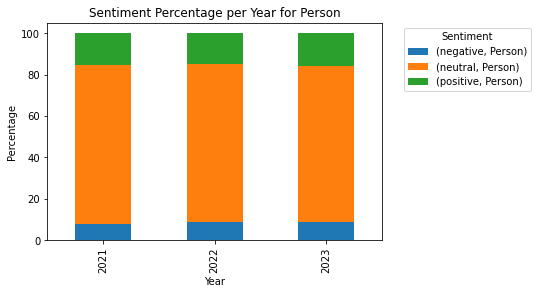

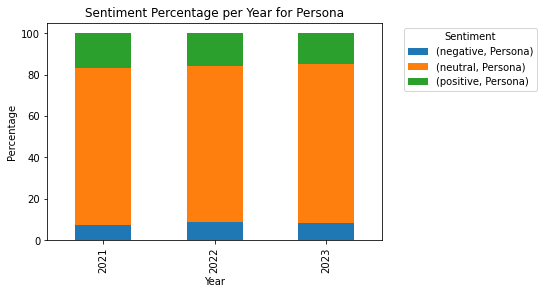

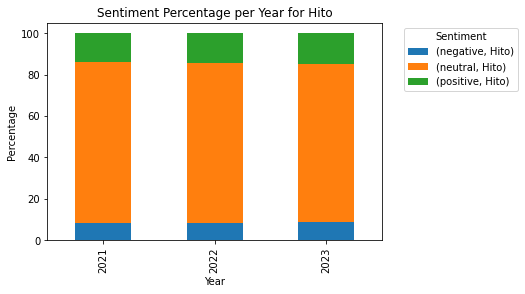

In [18]:
# Calculate the percentage of each sentiment per year per sender

#Create year column
dfFilter['Year'] = pd.to_datetime(dfFilter['Date']).dt.year

#Get it by year
sentiment_percentage_per_year_per_sender = dfFilter.groupby(['Year', 'Sender', 'Sentiment']).size().unstack(fill_value=0)
sentiment_percentage_per_year_per_sender = sentiment_percentage_per_year_per_sender.div(sentiment_percentage_per_year_per_sender.sum(axis=1), axis=0) * 100

# Plot the results using Matplotlib
for sender in dfFilter['Sender'].unique():
    data = sentiment_percentage_per_year_per_sender.loc[(slice(None), sender), :]
    ax = data.unstack().plot(kind='bar', stacked=True, title=f'Sentiment Percentage per Year for {sender}')
    plt.ylabel('Percentage')
    plt.xlabel('Year')
    plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
    if savefigs:
        plt.savefig(directory[:-1] + f"Sentiment Analysis for {sender}.png")           
    plt.show()

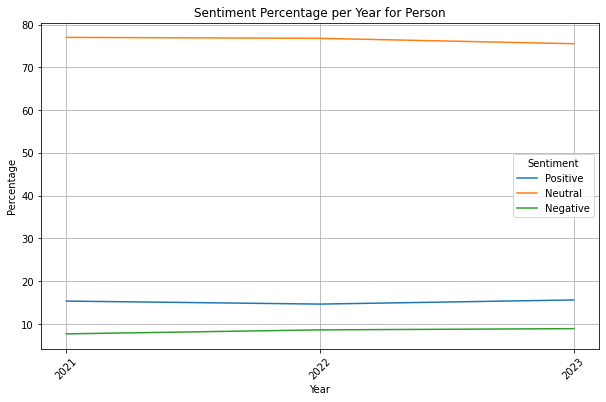

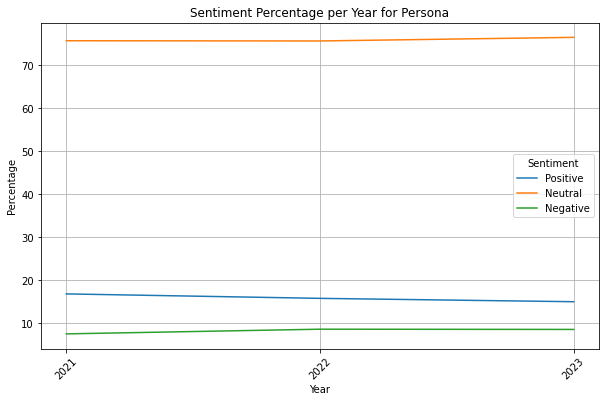

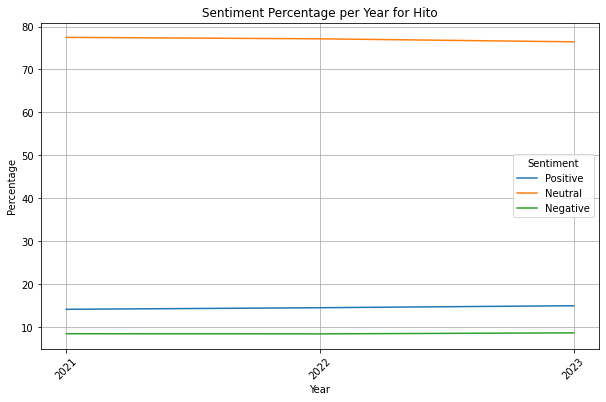

In [19]:
#Define senders to do more specific analysis
senders = dfFilter['Sender'].unique()
for sender in senders:
    data = sentiment_percentage_per_year_per_sender.loc[(slice(None), sender), :].unstack()
    
    plt.figure(figsize=(10, 6))
    
    for sentiment in ['positive', 'neutral', 'negative']:
        plt.plot(data[sentiment], label=sentiment.capitalize())
    
    plt.title(f'Sentiment Percentage per Year for {sender}')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.xticks(list(set(dfFilter['Year'])), rotation=45)  # Set x-axis ticks to unique years
    plt.legend(title='Sentiment',loc="best")
    plt.grid(True)
    if savefigs:
        plt.savefig(directory[:-1] + f"Sentiment Percentage Line Evolution for {sender}.png")
    plt.show()

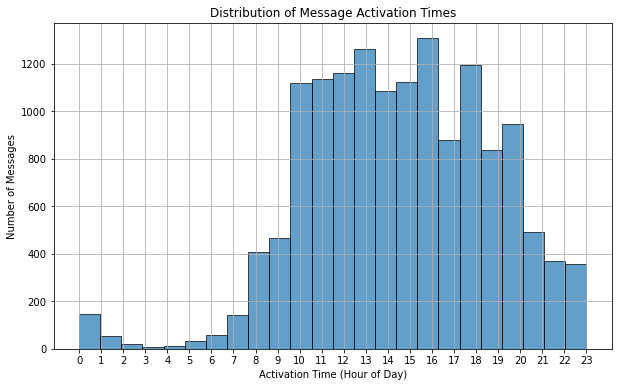

In [20]:
# Assuming 'Time' is in the format 'HH:MM:SS'. If not, adjust the format accordingly.
dfFilter['Activation_Time'] = pd.to_datetime(dfFilter['Time'], format='%H:%M').dt.hour

# Plot a histogram of message activation times
plt.figure(figsize=(10, 6))
plt.hist(dfFilter['Activation_Time'], bins=24, edgecolor='black', alpha=0.7)
plt.title('Distribution of Message Activation Times')
plt.xlabel('Activation Time (Hour of Day)')
plt.ylabel('Number of Messages')
plt.xticks(range(24))
plt.grid(True)
if savefigs:
    plt.savefig(directory[:-1] + "Activation Times.png")
plt.show()

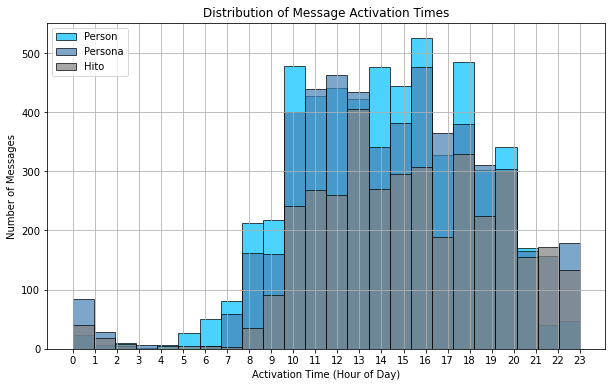

In [21]:
# Plot a histogram of message activation times
plt.figure(figsize=(10, 6))
for sender in senders:
    plt.hist(dfFilter[dfFilter['Sender'] == sender]['Activation_Time'], bins=24, edgecolor='black',color = colour_dict[sender], alpha=0.7,label = sender)
plt.title('Distribution of Message Activation Times')
plt.xlabel('Activation Time (Hour of Day)')
plt.ylabel('Number of Messages')
plt.xticks(range(24))
plt.legend(loc='upper left')
plt.grid(True)
if savefigs:
    plt.savefig(directory[:-1] + "Activation Times by Senders.png")
plt.show()